In [1]:
from lorenz96.numerical_model import lorenz96, lorenz96_twoscale
from utils import integral_system
import numpy as np

In [2]:
## Truth Orbit
np.random.seed(42)
N = 240
steps = 20000
state_truth_init = np.random.rand(N)
sol_truth = integral_system(state_truth_init, steps, lorenz96_twoscale)
print(state_truth_init)

[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258 0.02058449 0.96990985
 0.83244264 0.21233911 0.18182497 0.18340451 0.30424224 0.52475643
 0.43194502 0.29122914 0.61185289 0.13949386 0.29214465 0.36636184
 0.45606998 0.78517596 0.19967378 0.51423444 0.59241457 0.04645041
 0.60754485 0.17052412 0.06505159 0.94888554 0.96563203 0.80839735
 0.30461377 0.09767211 0.68423303 0.44015249 0.12203823 0.49517691
 0.03438852 0.9093204  0.25877998 0.66252228 0.31171108 0.52006802
 0.54671028 0.18485446 0.96958463 0.77513282 0.93949894 0.89482735
 0.59789998 0.92187424 0.0884925  0.19598286 0.04522729 0.32533033
 0.38867729 0.27134903 0.82873751 0.35675333 0.28093451 0.54269608
 0.14092422 0.80219698 0.07455064 0.98688694 0.77224477 0.19871568
 0.00552212 0.81546143 0.70685734 0.72900717 0.77127035 0.07404465
 0.35846573 0.11586906 0.86310343 0.62329813 0.33089802 0.06355835
 0.31098232 0.32518332 0.72960618 0.63755747 0.88721274 0.4722

In [3]:
## Error orbit
state_error_init = state_truth_init[0:40].copy()
sol_error = integral_system(state_error_init, steps, lorenz96)


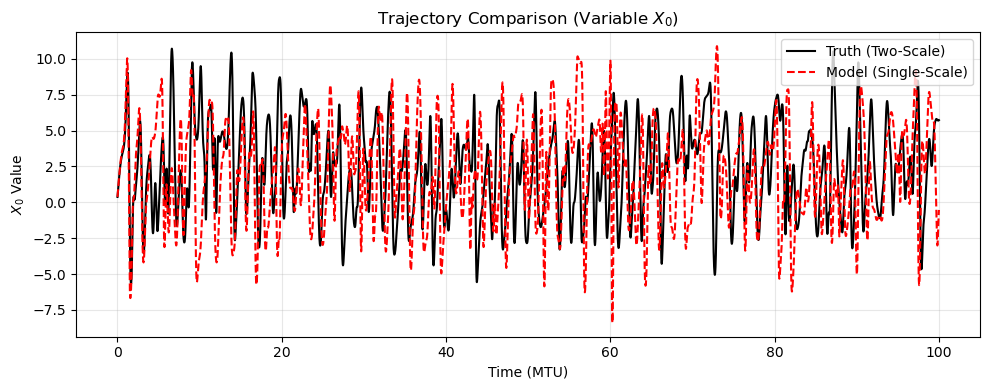

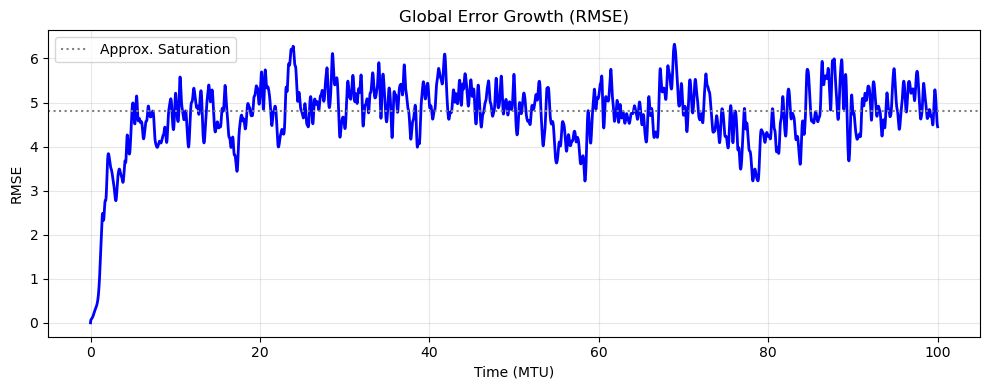

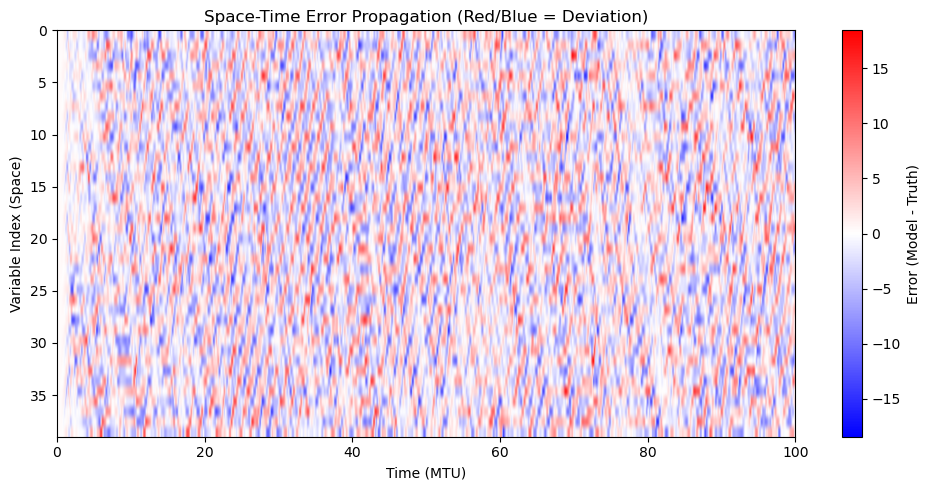

In [4]:
import matplotlib.pyplot as plt
K = 40
def plot_l96_error_growth_separate(sol_truth, sol_error, K, dt=None):
    """
    可视化 Lorenz 96 双尺度 (Truth) 与 单尺度 (Model) 的误差增长。
    分别生成三张独立的图片。

    参数:
    sol_truth : scipy.integrate.solve_ivp 的返回结果 (包含 slow + fast 变量)
    sol_error : scipy.integrate.solve_ivp 的返回结果 (仅包含 slow 变量)
    K         : 慢速变量的个数 (用于从 sol_truth 中提取 X)
    dt        : 时间步长 (占位符)
    """

    # ===========================
    # 1. 数据提取与计算 (保持不变)
    # ===========================
    # sol_truth.y 的形状是 (N, T)，我们需要前 K 行 (X变量)
    X_true = sol_truth.y[:K, :]
    # sol_error.y 的形状是 (K, T)
    X_model = sol_error.y

    # 时间轴
    t = sol_truth.t

    # 计算误差矩阵 (Space-Time Error)
    error_matrix = X_model - X_true

    # 计算均方根误差 (RMSE) 随时间的变化
    rmse = np.sqrt(np.mean(error_matrix ** 2, axis=0))

    # ===========================
    # 2. 绘图：分别创建三个 Figure
    # ===========================

    # --- Figure 1: 单个变量的时间序列对比 ---
    fig1, ax1 = plt.subplots(figsize=(10, 4))
    # 我们画第 0 个变量，看看它们什么时候开始分叉
    ax1.plot(t, X_true[0, :], 'k-', lw=1.5, label='Truth (Two-Scale)')
    ax1.plot(t, X_model[0, :], 'r--', lw=1.5, label='Model (Single-Scale)')
    ax1.set_ylabel(r'$X_0$ Value')
    # 因为不再共享X轴，这里需要添加X轴标签
    ax1.set_xlabel('Time (MTU)')
    ax1.set_title(f'Trajectory Comparison (Variable $X_0$)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    fig1.tight_layout()

    # --- Figure 2: RMSE 误差增长曲线 ---
    fig2, ax2 = plt.subplots(figsize=(10, 4))
    ax2.plot(t, rmse, 'b-', lw=2)
    ax2.set_ylabel('RMSE')
    # 添加X轴标签
    ax2.set_xlabel('Time (MTU)')
    ax2.set_title('Global Error Growth (RMSE)')
    ax2.grid(True, alpha=0.3)

    # 添加参考线 (确保数据足够长以避免索引错误)
    if len(rmse) > 200:
        saturation_val = np.mean(rmse[-200:])
    else:
        saturation_val = np.mean(rmse[-int(len(rmse)/5):]) # 取最后20%

    ax2.axhline(y=saturation_val, color='gray', linestyle=':', label='Approx. Saturation')
    ax2.legend()
    fig2.tight_layout()

    # --- Figure 3: 误差的时空分布 (Hovmöller Diagram) ---
    fig3, ax3 = plt.subplots(figsize=(10, 5))
    # 自动确定颜色范围
    limit = np.max(np.abs(error_matrix))
    # 绘图
    im = ax3.imshow(error_matrix, aspect='auto', cmap='bwr',
                    vmin=-limit, vmax=limit,
                    # extent 设置坐标轴范围: [t_min, t_max, y_max_index, y_min_index]
                    extent=[t[0], t[-1], K - 1, 0])

    ax3.set_ylabel('Variable Index (Space)')
    ax3.set_xlabel('Time (MTU)')
    ax3.set_title('Space-Time Error Propagation (Red/Blue = Deviation)')

    # 添加色标，注意要关联到 fig3
    cbar = fig3.colorbar(im, ax=ax3)
    cbar.set_label('Error (Model - Truth)')
    fig3.tight_layout()

    # 最后统一显示所有弹出的窗口
    plt.show()

plot_l96_error_growth_separate(sol_truth,sol_error,K = K, dt = 0.005)

In [5]:
### Save data
import os
import numpy as np
import pickle

# 1. 设置保存路径
base_path = '/Users/huanghongxiao/Desktop/Uchicago/Inverse Problem/HW/acm270_projects-main/Project 4/Data'

# 自动创建文件夹 (如果不存在的话)，防止报错
os.makedirs(base_path, exist_ok=True)

print(f"准备保存数据到: {base_path}")

# 2. 保存 state_truth_init (Numpy 数组)
# 保存为 .npy 文件
init_path = os.path.join(base_path, 'state_truth_init.npy')
np.save(init_path, state_truth_init)
print(f"  - state_truth_init 已保存")

# 3. 保存 sol_error (Solve_ivp 结果对象)
# 使用 pickle 保存复杂对象
error_path = os.path.join(base_path, 'sol_error.pkl')
with open(error_path, 'wb') as f:
    pickle.dump(sol_error, f)
print(f"  - sol_error 已保存")

# 4. 保存 sol_truth (Solve_ivp 结果对象)
truth_path = os.path.join(base_path, 'sol_truth.pkl')
with open(truth_path, 'wb') as f:
    pickle.dump(sol_truth, f)
print(f"  - sol_truth 已保存")

print("所有文件保存完毕！✅")



准备保存数据到: /Users/huanghongxiao/Desktop/Uchicago/Inverse Problem/HW/acm270_projects-main/Project 4/Data
  - state_truth_init 已保存
  - sol_error 已保存
  - sol_truth 已保存
所有文件保存完毕！✅


In [6]:
base_path = '/Users/huanghongxiao/Desktop/Uchicago/Inverse Problem/HW/acm270_projects-main/Project 4/Data'

# 1. 读取初始状态
state_truth_init = np.load(os.path.join(base_path, 'state_truth_init.npy'))
print(state_truth_init)

[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258 0.02058449 0.96990985
 0.83244264 0.21233911 0.18182497 0.18340451 0.30424224 0.52475643
 0.43194502 0.29122914 0.61185289 0.13949386 0.29214465 0.36636184
 0.45606998 0.78517596 0.19967378 0.51423444 0.59241457 0.04645041
 0.60754485 0.17052412 0.06505159 0.94888554 0.96563203 0.80839735
 0.30461377 0.09767211 0.68423303 0.44015249 0.12203823 0.49517691
 0.03438852 0.9093204  0.25877998 0.66252228 0.31171108 0.52006802
 0.54671028 0.18485446 0.96958463 0.77513282 0.93949894 0.89482735
 0.59789998 0.92187424 0.0884925  0.19598286 0.04522729 0.32533033
 0.38867729 0.27134903 0.82873751 0.35675333 0.28093451 0.54269608
 0.14092422 0.80219698 0.07455064 0.98688694 0.77224477 0.19871568
 0.00552212 0.81546143 0.70685734 0.72900717 0.77127035 0.07404465
 0.35846573 0.11586906 0.86310343 0.62329813 0.33089802 0.06355835
 0.31098232 0.32518332 0.72960618 0.63755747 0.88721274 0.4722

In [7]:
import pickle
import numpy as np
import os

current_dir = os.getcwd()
DATA_DIR= os.path.join(current_dir, "Data")

# 1. 读取 solve_ivp 的 sol 对象
with open(os.path.join(DATA_DIR, "sol_truth.pkl"), "rb") as f:
    sol_truth = pickle.load(f)

# 2. sol_truth.y 是状态矩阵，形状一般是 (state_dim, T)
# two-scale L96 的前 40 维 slow variables 是我们需要的真值
x_truth = sol_truth.y[:40, :]   # shape: (40, T)

# 3. 保存为 .npy（让后面的 RMSE 使用）
np.save(os.path.join(DATA_DIR, "x_truth.npy"), x_truth)

print("✔ Successfully loaded x_truth from sol_truth.pkl")
print("✔ Saved to:", os.path.join(DATA_DIR, "x_truth.npy"))
print("x_truth shape =", x_truth.shape)


✔ Successfully loaded x_truth from sol_truth.pkl
✔ Saved to: /Users/huanghongxiao/Desktop/Uchicago/Inverse Problem/HW/acm270_projects-main/Project 4/Data/x_truth.npy
x_truth shape = (40, 20001)
